## MNIST implementation of GeneGAN

https://arxiv.org/pdf/1705.04932.pdf

In [1]:
import numpy as np
import theano
from theano import tensor as T
import lasagne
from lasagne.layers import *
from lasagne.nonlinearities import *
from lasagne.objectives import *
from lasagne.updates import *
import sys

In [140]:
import matplotlib.pyplot as plt
%matplotlib inline

In [244]:
leaky_relu = LeakyRectify(0.2)

In [304]:
def print_network(l_out):
    for layer in get_all_layers(l_out):
        print layer.__class__.__name__, layer.output_shape, \
        "" if not hasattr(layer, 'nonlinearity') else layer.nonlinearity
    print "# params:", count_params(l_out)

In [298]:
def encoder(enc_size=64, feat_size=64):
    l_in_conv = InputLayer((None,1,28,28))
    conv_layer = l_in_conv
    for i in range(3):
        conv_layer = batch_norm(
            Conv2DLayer(conv_layer, num_filters=(i+1)*32, filter_size=3, stride=2, nonlinearity=leaky_relu)
        )
    conv_layer = batch_norm(
        Conv2DLayer(conv_layer, num_filters=(i+1)*32, filter_size=2, nonlinearity=leaky_relu)
    )
    l_enc = DenseLayer(conv_layer, num_units=enc_size, nonlinearity=leaky_relu)
    l_feat = DenseLayer(conv_layer, num_units=feat_size, nonlinearity=leaky_relu)
    return {"l_enc": l_enc, "l_feat": l_feat}

In [299]:
def decoder(enc_size=64, feat_size=64):
    l_in_enc = InputLayer((None, enc_size))
    l_in_feat = InputLayer((None, feat_size))
    l_concat = ConcatLayer((l_in_enc, l_in_feat))
    l_dense = batch_norm(DenseLayer(l_concat, 96*1*1, nonlinearity=leaky_relu))
    l_reshape = ReshapeLayer(l_dense, (-1, 96, 1, 1))
    deconv_layer = l_reshape
    for i in range(3, 0, -1):
        deconv_layer = batch_norm(
            Deconv2DLayer(deconv_layer, filter_size=3, num_filters=i*32, stride=2, nonlinearity=leaky_relu)
        )
    deconv_layer = Deconv2DLayer(
        deconv_layer, filter_size=4, num_filters=1, stride=2, crop=2, nonlinearity=sigmoid)
    return {"l_in_enc": l_in_enc, "l_in_feat": l_in_feat, "out": deconv_layer}

In [300]:
def discriminator():
    l_in_conv = InputLayer((None,1,28,28))
    conv_layer = l_in_conv
    for i in range(3):
        conv_layer = Conv2DLayer(
            conv_layer, num_filters=(i+1)*16, filter_size=3, stride=2, nonlinearity=leaky_relu)
    conv_layer = Conv2DLayer(
        conv_layer, num_filters=(i+1)*16, filter_size=2, nonlinearity=leaky_relu)
    l_sigm = DenseLayer(conv_layer, num_units=1, nonlinearity=sigmoid)
    return l_sigm

In [258]:
# do the A stuff
# l_in_feat = the object vector, l_in_enc = the encoding of the image

In [302]:
adv_loss = squared_error # for LSGAN

In [305]:
dd = encoder()
print_network(dd["l_feat"])

InputLayer (None, 1, 28, 28) 
Conv2DLayer (None, 32, 13, 13) <function linear at 0x114cb3668>
BatchNormLayer (None, 32, 13, 13) 
NonlinearityLayer (None, 32, 13, 13) <lasagne.nonlinearities.LeakyRectify object at 0x124f2d2d0>
Conv2DLayer (None, 64, 6, 6) <function linear at 0x114cb3668>
BatchNormLayer (None, 64, 6, 6) 
NonlinearityLayer (None, 64, 6, 6) <lasagne.nonlinearities.LeakyRectify object at 0x124f2d2d0>
Conv2DLayer (None, 96, 2, 2) <function linear at 0x114cb3668>
BatchNormLayer (None, 96, 2, 2) 
NonlinearityLayer (None, 96, 2, 2) <lasagne.nonlinearities.LeakyRectify object at 0x124f2d2d0>
Conv2DLayer (None, 96, 1, 1) <function linear at 0x114cb3668>
BatchNormLayer (None, 96, 1, 1) 
NonlinearityLayer (None, 96, 1, 1) <lasagne.nonlinearities.LeakyRectify object at 0x124f2d2d0>
DenseLayer (None, 64) <lasagne.nonlinearities.LeakyRectify object at 0x124f2d2d0>
# params: 118240


In [306]:
dd_dec = decoder()
print_network(dd_dec["out"])

InputLayer (None, 64) 
InputLayer (None, 64) 
ConcatLayer (None, 128) 
DenseLayer (None, 96) <function linear at 0x114cb3668>
BatchNormLayer (None, 96) 
NonlinearityLayer (None, 96) <lasagne.nonlinearities.LeakyRectify object at 0x124f2d2d0>
ReshapeLayer (None, 96, 1, 1) 
TransposedConv2DLayer (None, 96, 3, 3) <function linear at 0x114cb3668>
BatchNormLayer (None, 96, 3, 3) 
NonlinearityLayer (None, 96, 3, 3) <lasagne.nonlinearities.LeakyRectify object at 0x124f2d2d0>
TransposedConv2DLayer (None, 64, 7, 7) <function linear at 0x114cb3668>
BatchNormLayer (None, 64, 7, 7) 
NonlinearityLayer (None, 64, 7, 7) <lasagne.nonlinearities.LeakyRectify object at 0x124f2d2d0>
TransposedConv2DLayer (None, 32, 15, 15) <function linear at 0x114cb3668>
BatchNormLayer (None, 32, 15, 15) 
NonlinearityLayer (None, 32, 15, 15) <lasagne.nonlinearities.LeakyRectify object at 0x124f2d2d0>
TransposedConv2DLayer (None, 1, 28, 28) <function sigmoid at 0x114c97938>
# params: 170625


In [307]:
Au = T.tensor4('Au')
B0 = T.tensor4('B0')

In [308]:
A_for_Au, u_for_Au = get_output([dd['l_enc'], dd['l_feat']], Au)

In [309]:
decode_into_Au = get_output(
    dd_dec['out'], 
    {dd_dec['l_in_enc']: A_for_Au, dd_dec['l_in_feat']: u_for_Au}
)

In [310]:
decode_into_A0 = get_output(
    dd_dec['out'],
    {dd_dec['l_in_enc']: A_for_Au, dd_dec['l_in_feat']: T.zeros_like(u_for_Au)}
)

In [359]:
# debug
a = T.fmatrix('a')
decode_into_Au_using_custom_a = get_output(
    dd_dec['out'], 
    {dd_dec['l_in_enc']: A_for_Au, dd_dec['l_in_feat']: a}
)
#######

In [311]:
Au_recon_loss = T.abs_(decode_into_Au - Au).mean()

In [312]:
disc = discriminator()
print_network(disc)

InputLayer (None, 1, 28, 28) 
Conv2DLayer (None, 16, 13, 13) <lasagne.nonlinearities.LeakyRectify object at 0x124f2d2d0>
Conv2DLayer (None, 32, 6, 6) <lasagne.nonlinearities.LeakyRectify object at 0x124f2d2d0>
Conv2DLayer (None, 48, 2, 2) <lasagne.nonlinearities.LeakyRectify object at 0x124f2d2d0>
Conv2DLayer (None, 48, 1, 1) <lasagne.nonlinearities.LeakyRectify object at 0x124f2d2d0>
DenseLayer (None, 1) <function sigmoid at 0x114c97938>
# params: 27985


In [313]:
disc_for_A0 = get_output(disc, decode_into_A0)

In [314]:
disc_for_B0 = get_output(disc, B0)

In [315]:
# the discriminator returns the probability the image
# is a ground truth, i.e., it is B0, and not the predicted A0
disc_1_loss = adv_loss(disc_for_B0, 1.).mean() + adv_loss(disc_for_A0, 0.).mean()

In [316]:
Au_generator_loss = adv_loss(disc_for_A0, 1.).mean()

**Total loss: reconstruction error + GAN loss to distinguish A0 (fake) and B0 (real)**

In [317]:
total_generator_loss = Au_generator_loss + Au_recon_loss

In [318]:
total_generator_loss.eval({Au: np.ones((10,1,28,28))})

array(0.7567213736559597)

-------------

In [319]:
B_for_B0, eps_for_B0 = get_output([dd['l_enc'], dd['l_feat']], B0)

In [320]:
decode_into_Bu = get_output(
    dd_dec['out'], 
    {dd_dec['l_in_enc']: B_for_B0, dd_dec['l_in_feat']: u_for_Au}
)

In [321]:
decode_into_B0 = get_output(
    dd_dec['out'], 
    {dd_dec['l_in_enc']: B_for_B0, dd_dec['l_in_feat']: T.zeros_like(u_for_Au)}
)

In [322]:
eps_loss = T.abs_(eps_for_B0).mean()

In [323]:
B0_recon_loss = T.abs_(decode_into_B0 - B0).mean()

In [324]:
disc2 = discriminator()
print_network(disc2)

InputLayer (None, 1, 28, 28) 
Conv2DLayer (None, 16, 13, 13) <lasagne.nonlinearities.LeakyRectify object at 0x124f2d2d0>
Conv2DLayer (None, 32, 6, 6) <lasagne.nonlinearities.LeakyRectify object at 0x124f2d2d0>
Conv2DLayer (None, 48, 2, 2) <lasagne.nonlinearities.LeakyRectify object at 0x124f2d2d0>
Conv2DLayer (None, 48, 1, 1) <lasagne.nonlinearities.LeakyRectify object at 0x124f2d2d0>
DenseLayer (None, 1) <function sigmoid at 0x114c97938>
# params: 27985


In [325]:
disc_for_Au = get_output(disc2, decode_into_Au)
disc_for_Bu = get_output(disc2, decode_into_Bu)

In [326]:
# the discriminator returns the probability the image
# is a ground truth, i.e., it is Au, and not the predicted Bu
disc_2_loss = adv_loss(disc_for_Au, 1.).mean() + adv_loss(disc_for_Bu, 0.).mean()

In [327]:
Bu_generator_loss = adv_loss(disc_for_Bu, 1.).mean()

**Total loss: reconstruction error + GAN loss to distinguish Bu (fake) and Au (real)**

In [328]:
total_generator_loss_2 = Bu_generator_loss + B0_recon_loss + eps_loss

-------

In [329]:
total_loss = total_generator_loss + total_generator_loss_2

-------

Load in the dataset n shit

In [122]:
def load_dataset():
    # We first define a download function, supporting both Python 2 and 3.
    import sys
    import os
    if sys.version_info[0] == 2:
        from urllib import urlretrieve
    else:
        from urllib.request import urlretrieve

    def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
        print("Downloading %s" % filename)
        urlretrieve(source + filename, filename)

    # We then define functions for loading MNIST images and labels.
    # For convenience, they also download the requested files if needed.
    import gzip

    def load_mnist_images(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the inputs in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        # The inputs are vectors now, we reshape them to monochrome 2D images,
        # following the shape convention: (examples, channels, rows, columns)
        data = data.reshape(-1, 1, 28, 28)
        # The inputs come as bytes, we convert them to float32 in range [0,1].
        # (Actually to range [0, 255/256], for compatibility to the version
        # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
        return data / np.float32(256)

    def load_mnist_labels(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the labels in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        # The labels are vectors of integers now, that's exactly what we want.
        return data

    # We can now download and read the training and test set images and labels.
    X_train = load_mnist_images('train-images-idx3-ubyte.gz')
    y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
    X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
    y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

    # We reserve the last 10000 training examples for validation.
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    # We just return all the arrays in order, as expected in main().
    # (It doesn't matter how we do this as long as we can read them again.)
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, _, _, _, _ = load_dataset()


In [220]:
X_Au = X_train[y_train == 9]
X_B0 = X_train[y_train == 0]

In [221]:
def iterator(Au_full, B0_full, bs=32, shuffle=True):
    n_min = min(Au_full.shape[0], B0_full.shape[0])
    if shuffle:
        np.random.shuffle(Au_full)
        np.random.shuffle(B0_full)
    for b in range(n_min // bs):
        yield Au_full[b*bs:(b+1)*bs], B0_full[b*bs:(b+1)*bs]

In [223]:
for xx, yy in iterator(X_Au, X_B0):
    break

---------

In [330]:
gen_params = get_all_params(ConcatLayer([dd['l_enc'], dd['l_feat']]), trainable=True)

In [331]:
disc_params = get_all_params(dd_dec['out'], trainable=True)

In [332]:
tot_gen_params = gen_params + disc_params

In [333]:
disc1_params = get_all_params(disc, trainable=True)

In [334]:
disc2_params = get_all_params(disc2, trainable=True)

In [335]:
gen_updates = adam(total_loss, tot_gen_params, learning_rate=1e-4)

In [336]:
gen_updates.update(adam(disc_1_loss, disc1_params, learning_rate=1e-4))

In [337]:
gen_updates.update(adam(disc_2_loss, disc2_params, learning_rate=1e-4))

In [338]:
train_fn = theano.function([Au, B0],
                           [total_loss, disc_1_loss, disc_2_loss], 
                           updates=gen_updates)

In [339]:
for epoch in range(10):
    losses_a, losses_b, losses_c = [], [], []
    for X_Au_batch,X_B0_batch in iterator(X_Au, X_B0):
        a,b,c = train_fn(X_Au_batch,X_B0_batch)
        losses_a.append(a)
        losses_b.append(b)
        losses_c.append(c)
    print np.mean(losses_a), np.mean(losses_b), np.mean(losses_c)

1.56974790178 0.366790527241 0.499946535981
1.30809334149 0.269076464323 0.499692169942
1.22678785255 0.303944462559 0.499588043248
1.181036347 0.268119846268 0.499749043189
1.13398245274 0.294923282009 0.499700601583
1.04546600998 0.471262925362 0.499147750602
0.97069957688 0.468375154016 0.499383119647
0.89044532306 0.537225709767 0.497100086387
0.911976017968 0.509977423559 0.487900220992
0.871872183899 0.508109644562 0.484657152755


In [341]:
enc_fn = theano.function([Au], [A_for_Au, u_for_Au])

In [349]:
zero_fn = theano.function([Au], decode_into_A0)

In [360]:
# if we compute the norms of the latent vectors for Au...

In [346]:
np.sum(enc_fn(X_Au[0:10])[1]**2)

56.571419513566241

In [362]:
# if we compute the norms of the latent vectors for B0,
# we expect something very small compared to the above result...

In [348]:
np.sum(enc_fn(X_B0[0:10])[1]**2)

0.1489140986336929

'Au' images consist of 9's. If we encode it into its internal representation + a latent vector, the latter of which represents the vertical line in the 9, if we zero out this latent vector and decode, we get a zero...

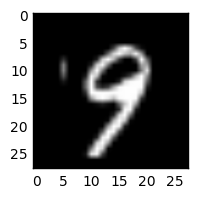

In [427]:
plt.figure(figsize=(2,2))
plt.imshow(X_Au[0][0],cmap="gray")

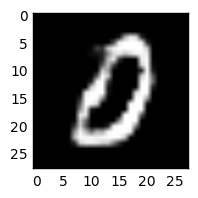

In [428]:
plt.figure(figsize=(2,2))
plt.imshow( zero_fn(X_Au[0:10])[0][0], cmap="gray" )

Let's extract the latent vector for one of the Au's. Then, let's encode a B0, then decode it using this latent vector.

In [363]:
decode_into_Au_using_custom_a_fn = theano.function([Au, a], decode_into_Au_using_custom_a)

In [420]:
latent_as = enc_fn(X_Au[30:40])[1].astype("float32")

In [421]:
latent_as.shape

(10, 64)

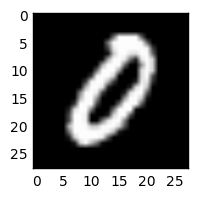

In [422]:
plt.figure(figsize=(2,2))
plt.imshow(X_B0[0,0],cmap="gray")

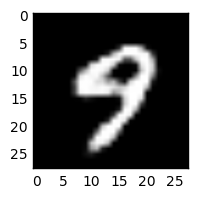

In [424]:
plt.figure(figsize=(2,2))
plt.imshow( decode_into_Au_using_custom_a_fn(X_B0[0:10], latent_as)[0][0], cmap="gray" )

Yay!

In [419]:

for epoch in range(100):
    losses_a, losses_b, losses_c = [], [], []
    for X_Au_batch,X_B0_batch in iterator(X_Au, X_B0):
        a,b,c = train_fn(X_Au_batch,X_B0_batch)
        losses_a.append(a)
        losses_b.append(b)
        losses_c.append(c)
    print np.mean(losses_a), np.mean(losses_b), np.mean(losses_c)

0.670786392688 0.506945238139 0.500242346431
0.66320643243 0.50450291419 0.499839959788
0.66485544529 0.501729613375 0.499672061559
0.675553813244 0.50329004293 0.500330868665
0.663759119795 0.503882844374 0.500946478516
0.651019933992 0.504968157282 0.501001056409
0.645012095402 0.503652011956 0.501157769591
0.650671883932 0.502305130476 0.500043699695
0.641474771239 0.501798344978 0.500956928277
0.636343725422 0.500943693599 0.500905381743
0.631245188169 0.500878361488 0.501760239177
0.62672372902 0.501147866041 0.501332157878
0.61912745511 0.501301252882 0.501275232151
0.615843197125 0.501697192933 0.500655531149
0.613576048111 0.50167076048 0.500782605541
0.614483444533 0.501440252877 0.500638038141
0.611943673615 0.500473071655 0.500194106217
0.607380552961 0.500684905823 0.500766550709
0.60785606111 0.500480962906 0.500761197821
0.606177979718 0.500462500352 0.501518528045
0.600502292774 0.499893723687 0.500287879444
0.600282932915 0.500011666489 0.50002835237
0.599382976287 0.50

KeyboardInterrupt: 